# **Détection du Glaucome à l'aide du Transfer Learning**

## **Chargement des données:**

Importation des packages:

In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"meryemdouider","key":"e6d4d9e76ba23b2dc984f747113db5ce"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download "sshikamaru/glaucoma-detection"

kaggle.json
glaucoma-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip glaucoma-detection.zip

Archive:  glaucoma-detection.zip
replace Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/001.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/002.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/003.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/004.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/005.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/006.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/007.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/008.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/009.jpg  
  inflating: Fundus_Train_Val_Dat

## **Préparation des données Train / Test / Validation:**


In [ ]:
DATAGlua_Train = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
DATAGlua_Test = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

In [ ]:
CATEGORIES  = list()
for root, dirs, files in os.walk(DATAGlua_Train, topdown=False):
    for name in dirs:
        CATEGORIES.append(os.path.join(name))
print (CATEGORIES)

['Glaucoma_Positive', 'Glaucoma_Negative']



Division l'ensemble de données d'entraînement en x_train_data et y_train_data  : (x_train_data : 'les images' , y_train_data : 'label / catégorie ')

In [ ]:
x_train_data = []
y_train_data = []
IMG_SIZE=224
def creation_train_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Train, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_train_data.append(new_array)
            y_train_data.append(class_num)
        except Exception as e:
            pass
creation_train_data()

Division l'ensemble de données test en x_test_data et y_test_data  : (x_test_data : 'les images' , y_test_data : 'label / catégorie ')




In [ ]:
x_test_data = []
y_test_data = []
IMG_SIZE=224
def creation_test_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Test, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_test_data.append(new_array)
            y_test_data.append(class_num)
        except Exception as e:
            pass
creation_test_data ()

Division l'ensemble de données x_train_data et y_train_data en données d’entraînement (X_Train,Y_Train) et données de validation   (Y_train,Y_val) 

In [ ]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(x_train_data, y_train_data, test_size=0.05, random_state=1)

In [ ]:
len(Y_Train)

494

In [ ]:
len(Y_Val)

26

In [ ]:
X_Train = np. squeeze(np.array(X_Train))
X_Val = np. squeeze(np.array(X_Val))
Y_Train = np. squeeze(np.array(Y_Train))
Y_Val = np. squeeze(np.array(Y_Val))
x_test_data = np. squeeze(np.array(x_test_data))

In [ ]:
X_Train.shape

(494, 224, 224, 3)

In [ ]:
X_Val.shape

(26, 224, 224, 3)

In [ ]:
Y_Train.shape

(494,)

In [ ]:
Y_Val.shape

(26,)

In [ ]:
x_test_data.shape

(130, 224, 224, 3)

In [ ]:
Y_Train = to_categorical(Y_Train)
Y_Val = to_categorical(Y_Val)

In [ ]:
Y_Train.shape

(494, 2)

In [ ]:
Y_Val.shape

(26, 2)

## **Création du modèle 2:**


**Inception v3**

Inceptionv3 est un réseau neuronal convolutif destiné à aider à l'analyse d'images et à la détection d'objets, et a fait ses débuts en tant que module pour Googlenet. Il s'agit de la troisième édition du Inception Convolutional Neural Network de Google, initialement présenté lors du Défi de reconnaissance ImageNet. Tout comme ImageNet peut être considéré comme une base de données d'objets visuels classifiés, Inception facilite la classification des objets dans le monde de la vision par ordinateur. Une de ces utilisations est dans les sciences de la vie, où elle aide à la recherche sur la leucémie. Le nom original (Inception) a été nommé de cette façon après qu'un mème Internet populaire «nous devons aller plus loin» est devenu viral, citant une phrase du film Inception de Christopher Nolan. 
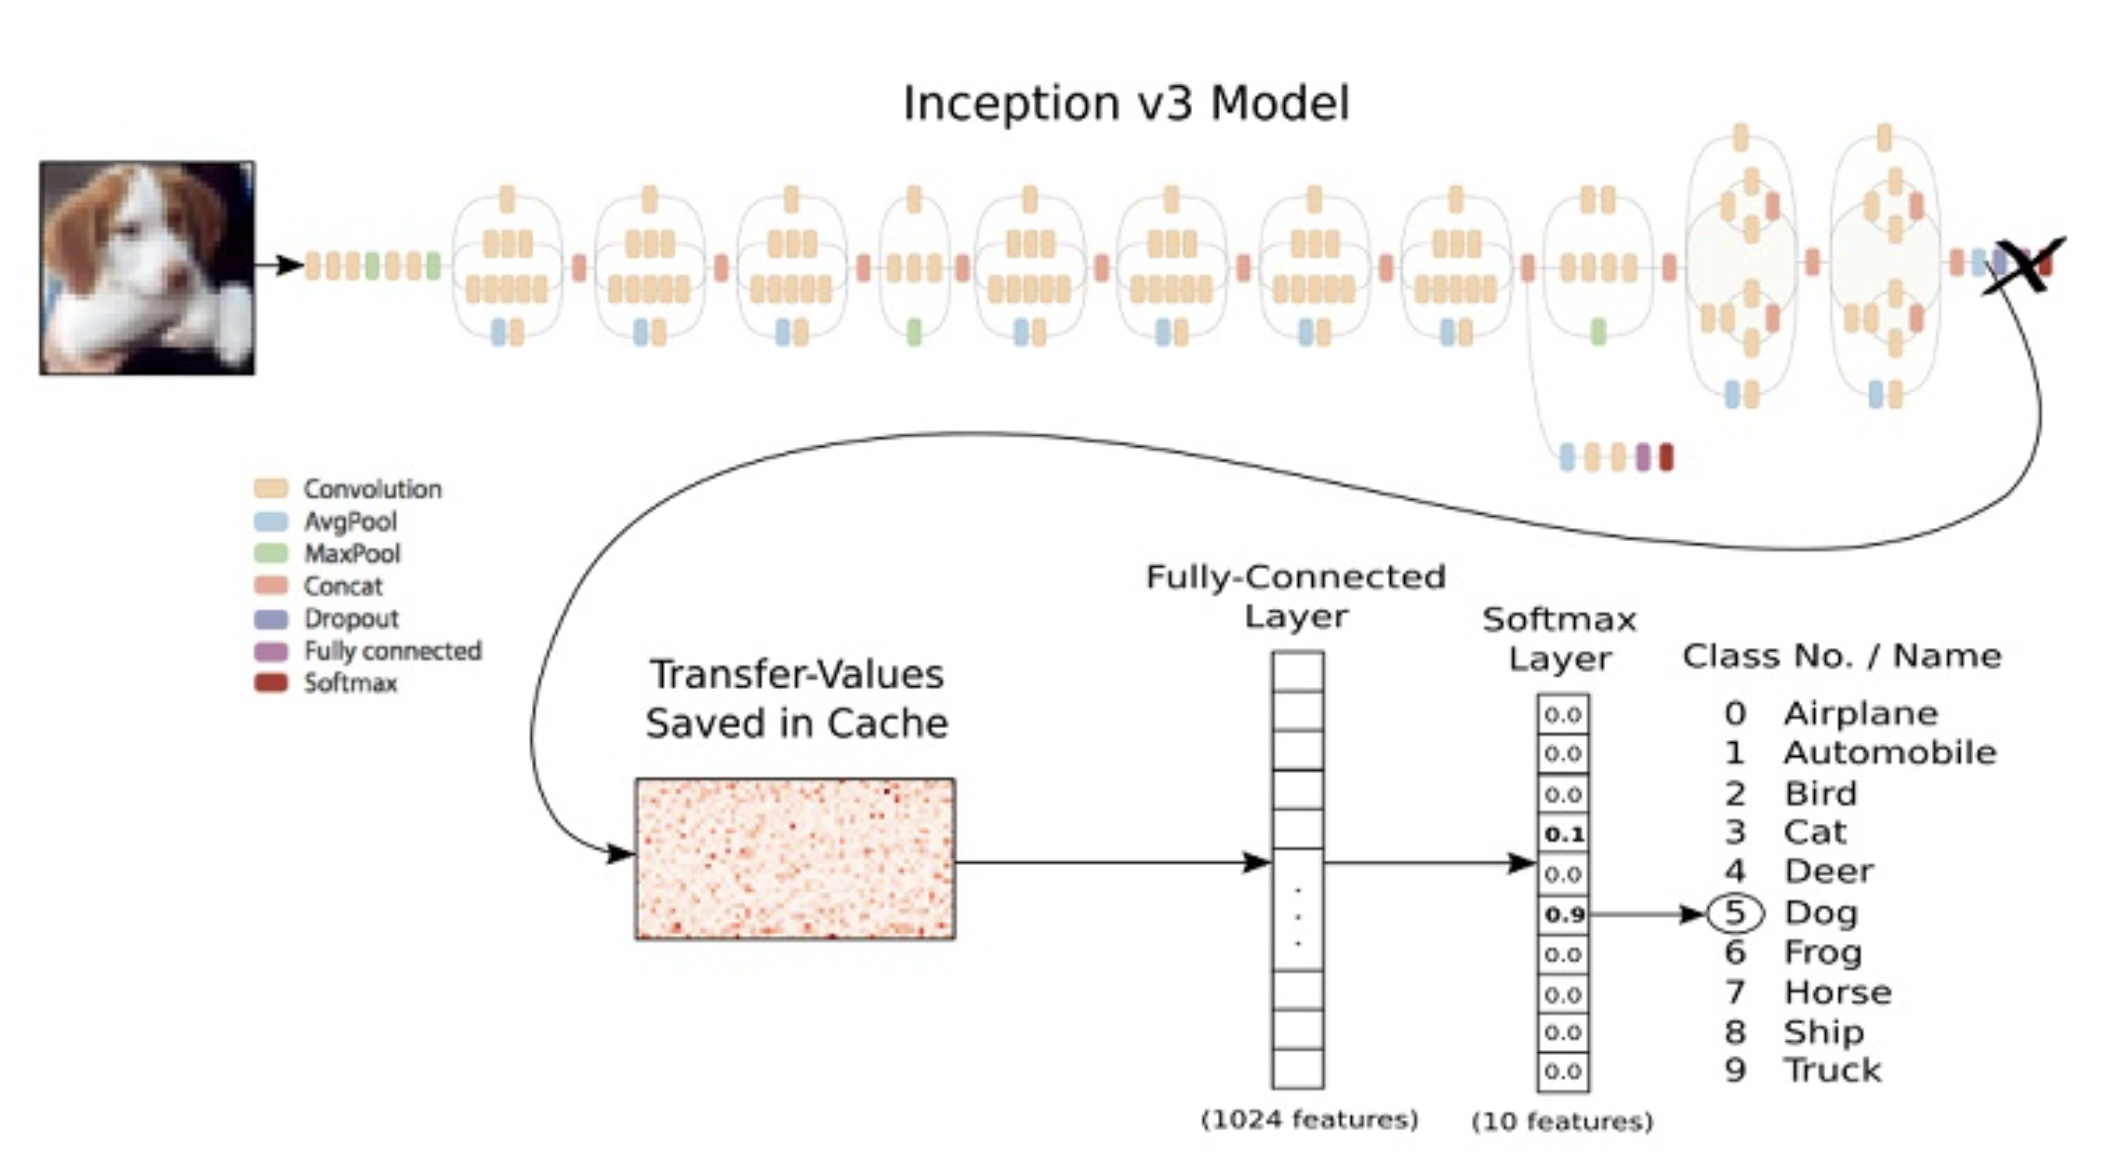
https://software.intel.com/content/www/us/en/develop/articles/inception-v3-deep-convolutional-architecture-for-classifying-acute-myeloidlymphoblastic.html


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
IMG_SHAPE = (224, 224,3)

Importer le modèle pré-entraîné Inception V3:

In [ ]:
base_model1 = InceptionV3(include_top=False,
                   input_shape=IMG_SHAPE,
                   pooling='avg',classes=2,
                   weights='imagenet')

Afficher les layers du modèle Inception v3 et figer le modèle pré-entraîné en utilisant la commande layer.trainable = False:

In [ ]:
for layer in base_model1.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(base_model1.layers))

input_5
conv2d_376
batch_normalization_376
activation_376
conv2d_377
batch_normalization_377
activation_377
conv2d_378
batch_normalization_378
activation_378
max_pooling2d_16
conv2d_379
batch_normalization_379
activation_379
conv2d_380
batch_normalization_380
activation_380
max_pooling2d_17
conv2d_384
batch_normalization_384
activation_384
conv2d_382
conv2d_385
batch_normalization_382
batch_normalization_385
activation_382
activation_385
average_pooling2d_36
conv2d_381
conv2d_383
conv2d_386
conv2d_387
batch_normalization_381
batch_normalization_383
batch_normalization_386
batch_normalization_387
activation_381
activation_383
activation_386
activation_387
mixed0
conv2d_391
batch_normalization_391
activation_391
conv2d_389
conv2d_392
batch_normalization_389
batch_normalization_392
activation_389
activation_392
average_pooling2d_37
conv2d_388
conv2d_390
conv2d_393
conv2d_394
batch_normalization_388
batch_normalization_390
batch_normalization_393
batch_normalization_394
activation_388
acti

In [ ]:
base_model1.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 111, 111, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 111, 111, 32) 0           batch_normalization_376[0][0]    
_______________________________________________________________________________________

In [ ]:
base_model1.trainable = False

In [ ]:
from tqdm import tqdm_notebook
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model
from keras.optimizers import RMSprop


Création d'un nouveau modèle qui va se baser sur les résultats du modèle pré-entraîné:

In [ ]:
x = Flatten ()(base_model1.output)
# Ajouter 4 hidden layers avec la fonction d'activation ReLU
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
# Ajouter une dernière couche sigmoïde pour la classification
x = layers.Dense(2, activation='sigmoid')(x)

In [ ]:
# Configurer et compiler le modèle
model1 = Model(base_model1.input, x)
optimizer = RMSprop(lr=0.0001)
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 111, 111, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 111, 111, 32) 0           batch_normalization_376[0][0]    
____________________________________________________________________________________________

### **Utilisation de ImageDataGenerator pour augmenter les données du test et normaliser les données:**

Augmentation et normalisation des données test :

In [ ]:
train_datagen = ImageDataGenerator(
    validation_split=0.2, 
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.02,
)
train_iterator= train_datagen.flow(
    x=X_Train,
    y=Y_Train,
    batch_size=16,
    subset='training'
)

Résultats de l'augmentation sur une image des données test :

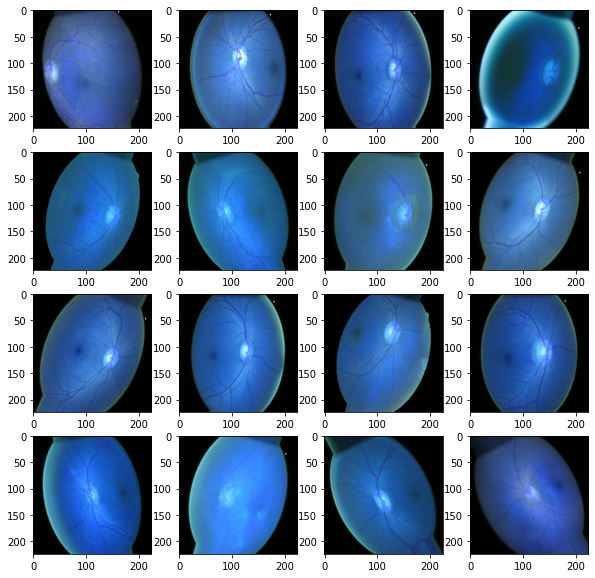

In [ ]:

plt.gcf().set_size_inches(10, 10)
for x_batch, y_batch in train_iterator:
    for i in range(0, 16):
        plt.subplot(4, 4, i+1)
        plt.imshow(x_batch[i])
    break

Normalisation des données validation :

In [ ]:
val_datagen=ImageDataGenerator(rescale=1./255)

Entraînement du modèle avec des layers du modèle pré-entraîné (en mode freeze):

In [ ]:
train_model = model1.fit(train_iterator,epochs=20,
                    validation_data=val_datagen.flow(X_Val, Y_Val))

Epoch 1/20
25/25 [==============================] - 10s 264ms/step - loss: 0.7696 - accuracy: 0.6461 - val_loss: 0.5176 - val_accuracy: 0.8462
Epoch 2/20
25/25 [==============================] - 4s 171ms/step - loss: 0.6025 - accuracy: 0.7061 - val_loss: 0.4571 - val_accuracy: 0.8462
Epoch 3/20
25/25 [==============================] - 4s 169ms/step - loss: 0.5821 - accuracy: 0.7242 - val_loss: 0.5373 - val_accuracy: 0.8077
Epoch 4/20
25/25 [==============================] - 4s 170ms/step - loss: 0.5185 - accuracy: 0.7595 - val_loss: 0.4621 - val_accuracy: 0.8077
Epoch 5/20
25/25 [==============================] - 4s 167ms/step - loss: 0.4721 - accuracy: 0.8189 - val_loss: 0.4277 - val_accuracy: 0.8462
Epoch 6/20
25/25 [==============================] - 4s 169ms/step - loss: 0.5059 - accuracy: 0.7598 - val_loss: 0.4281 - val_accuracy: 0.8077
Epoch 7/20
25/25 [==============================] - 4s 168ms/step - loss: 0.4494 - accuracy: 0.8108 - val_loss: 0.5082 - val_accuracy: 0.8462
Epoch

## **Fine-tuning:**

In [ ]:
for layer in model1.layers:
    layer.trainable = True

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 111, 111, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 111, 111, 32) 0           batch_normalization_376[0][0]    
____________________________________________________________________________________________

In [ ]:
train_model = model1.fit(train_iterator, epochs=25,
                    validation_data=val_datagen.flow(X_Val, Y_Val))

Epoch 1/25
25/25 [==============================] - 11s 244ms/step - loss: 0.7882 - acc: 0.4148 - val_loss: 0.4192 - val_acc: 0.7692
Epoch 2/25
25/25 [==============================] - 5s 198ms/step - loss: 0.6303 - acc: 0.6405 - val_loss: 0.4046 - val_acc: 0.7692
Epoch 3/25
25/25 [==============================] - 5s 201ms/step - loss: 0.5662 - acc: 0.7394 - val_loss: 0.4237 - val_acc: 0.8077
Epoch 4/25
25/25 [==============================] - 5s 200ms/step - loss: 0.5441 - acc: 0.7111 - val_loss: 0.4233 - val_acc: 0.8462
Epoch 5/25
25/25 [==============================] - 5s 201ms/step - loss: 0.5349 - acc: 0.7380 - val_loss: 0.4331 - val_acc: 0.8077
Epoch 6/25
25/25 [==============================] - 5s 198ms/step - loss: 0.5394 - acc: 0.7239 - val_loss: 0.4218 - val_acc: 0.8077
Epoch 7/25
25/25 [==============================] - 5s 199ms/step - loss: 0.5092 - acc: 0.7544 - val_loss: 0.4014 - val_acc: 0.8462
Epoch 8/25
25/25 [==============================] - 5s 199ms/step - loss: 0

In [ ]:
validation_data=val_datagen.flow(X_Val, Y_Val)

In [ ]:
loss_val, acc_val = model1.evaluate(validation_data, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1/1 [==============================] - 0s 132ms/step - loss: 0.2635 - acc: 0.9231
Validation: accuracy = 0.923077  ;  loss_v = 0.263504


In [ ]:
model1.save("V3")

INFO:tensorflow:Assets written to: V3/assets


Text(0.5, 1.0, 'Training and validation loss')

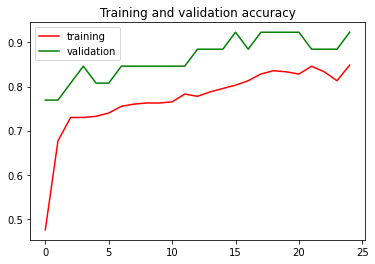

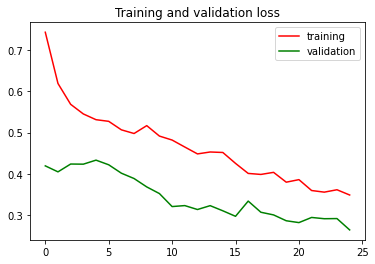

In [ ]:
#accuracy est un moyen de mesurer la fréquence à laquelle l'algorithme classe correctement un point de données.
# acc contient les valeurs des accuracy pour les données test  :
acc = train_model.history['acc']
# val_acc contient les valeurs des accuracy pour les données validation   :
val_acc = train_model.history['val_acc']

#loss_function : Cette fonction calculera essentiellement les performances de notre modèle en comparant ce que le modèle prédit avec la valeur réelle qu'il est censé produire.
# loss contient les valeurs du loss_function pour les données test  :
loss = train_model.history['loss']
# val_loss contient les valeurs du loss_function pour les données validation  :
val_loss = train_model.history['val_loss']

#le nombre des epochs pour comparer les valeurs des accuracy ou les valeurs des loss function par rapport à leur évolution et par rapport au nomre des epochs
epochs = range(len(acc))

# le premier graphe représente les valeurs des accuracy pour les données test et validation par rapport au nombre des epochs 
plt.plot(epochs, acc,color='r',label = "training")
plt.plot(epochs, val_acc,color='g',label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()
#le deuxième graphe représente les valeurs des accuracy pour les données test et validation par rapport au nombre des epochs 
plt.plot(epochs, loss,color='r', label = "training")
plt.plot(epochs, val_loss,color='g',label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')